In [2]:
%matplotlib inline
import matplotlib


In [3]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg


In [49]:
#load data
print "loading data"
#iterate over directory and get all png images\n
imageset = np.zeros((7704,64,64,3))

#There are 7704 images in the dataset.
#214 folders. Each having 36 images.
rootdir = '/home/chsarath/kaushal_project/mug/models/3dw'
cnt = 0
total_cnt = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith('.png'):
            if cnt == 36:
                cnt = 0
                total_cnt += 1
            cnt += 1
            seq_number = int(filepath.split('-')[-1].split('.')[0])
            
            imageset[total_cnt*36 + seq_number] = scipy.misc.imread(filepath)
            
print 'loading done'

loading data
loading done


(64, 64, 3)


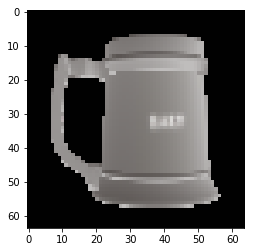

In [31]:
#this part is to visulize image
tmp = imageset[2260][...,::-1]
print tmp.shape
plt.imshow(tmp)
plt.show()

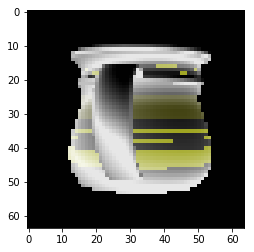

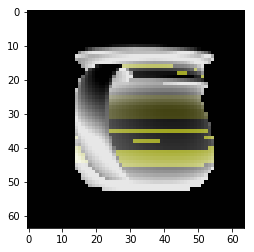

In [60]:
#First 170 folders. 170*36 = 6120 images would be used for training
# rest 46 folders would be used for testing

data_train = imageset[:6120]
data_test = imageset[6120:]


#This code will generate labels for the dataset

# For current image label is the next image (image with 10 degree rotation)
# For last image in the set (36th image) label would be first image

train_labels = np.zeros(data_train.shape)
test_labels = np.zeros(data_test.shape)

for cnt in range(170):
    train_labels[cnt*36:(cnt+1)*36] = np.roll(data_train[cnt*36:(cnt+1)*36], 1, axis=0)

for cnt in range(46):
    test_labels[cnt*36:(cnt+1)*36] = np.roll(data_test[cnt*36:(cnt+1)*36], 1, axis=0)


# tmp = data_train[35]
# tmp1 = train_labels[35]


# plt.imshow(tmp)
# plt.show()
# plt.imshow(tmp1)
# plt.show()


In [61]:
#normalize data


mean_image = np.mean(data_train, axis=0)
max_image = np.amax(data_train, axis=0)

data_train -= mean_image
data_train /= max_image

data_test -= mean_image
data_test /= max_image


mean_labels = np.mean(train_labels, axis=0)
max_labels = np.amax(train_labels, axis=0)

train_labels -= mean_labels
train_labels /= max_labels

test_labels -= mean_labels
test_labels /= max_labels

In [16]:
#defination of my layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape[3]]
    out_shape = [input.get_shape[0], input.get_shape[1]*2, input.get_shape[1]*2, num_filter]
    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape)

In [3]:

# Network Parameters

#Encoder
# input is 64 * 64 * 3 
# batch_size is 72


# tf Graph input (only pictures)

inputs_ = tf.placeholder(tf.float32, (None, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (None, 64,64,3), name="target")

In [ ]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Max pool + Conv + relu  + Max pool + Conv + relu  + Max pool
# After 3 Convolution ,we will have a latent space

with tf.variable_scope('conv1'):
    conv1 = conv2d(inputs_, 7, 1, 32)
    tanh1 = tf.nn.tanh(conv1)
    pool1 = max_pool(tanh1, 3, 2)

# Size of pool1 would be 32*32*32

with tf.variable_scope('conv2'):
    conv2 = conv2d(pool1, 5, 1, 16)
    tanh2 = tf.nn.tanh(conv2)
    pool2 = max_pool(tanh2, 3, 2)
    
# Size of pool2 would be 16*16*16

with tf.variable_scope('conv3'):
    conv3 = conv2d(pool2, 3, 1, 8)
    tanh3 = tf.nn.tanh(conv3)
    pool3 = max_pool(tanh3, 3, 2)

# Latent space is 8*8*8

#Building the decoder

with tf.variable_scope('deconv1'):
    deconv1 = deconv2d(pool3, 3, 1, 16)
    tanh4 = tf.nn.tanh(deconv1)

with tf.variable_scope('deconv2'):
    deconv2 = deconv2d(tanh4, 5, 1, 32)
    tanh5 = tf.nn.tanh(deconv2)

with tf.variable_scope('deconv3'):
    deconv3 = deconv2d(tanh5, 7, 1, 64)
    tanh6 = tf.nn.tanh(deconv3)





In [ ]:

#calculate loss
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits))

#Optimizer
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)



In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training Parameters

epochs = 20
batch_size = 72
total_images = 6120

display_step = 1000
examples_to_show = 10


for e in range(epochs):
    for ii in range(total_images//batch_size):
        batch = data_train[ii*batch_size:(ii+1)*batch_size]
        
        
print("Epoch: {}/{}...".format(e+1, epochs),
    "Training loss: {:.4f}".format(batch_cost))